In [65]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs

from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [67]:
sales = pd.read_csv('70prod_data.csv',\
                    index_col=0, parse_dates=True)

In [68]:
cluster_8 = sales.loc[:, ["P_3", "P_21", "P_23", "P_24", "P_56"]]
cluster_8.head()

,P_3,P_21,P_23,P_24,P_56
2014-07-31,3506,16302,21457,7204,4134
2014-08-31,3279,16907,22408,7477,4556
2014-09-30,3238,16286,21252,7592,4788
2014-10-31,3088,15147,20512,7435,4525
2014-11-30,2921,15298,22433,7434,4412


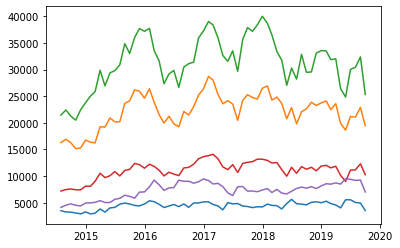

In [69]:
plt.plot(cluster_8)

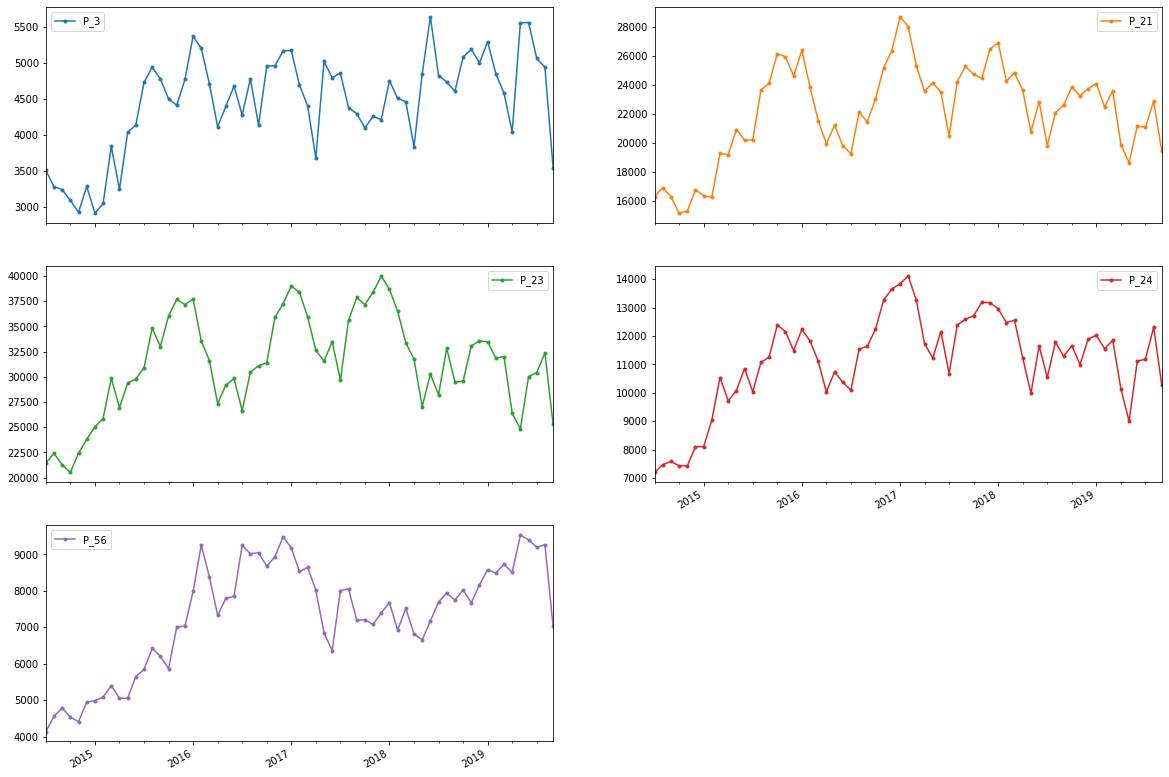

In [95]:
cluster_8.plot(subplots=True,layout=(3,2),figsize=(20,15), marker='.')
plt.show()

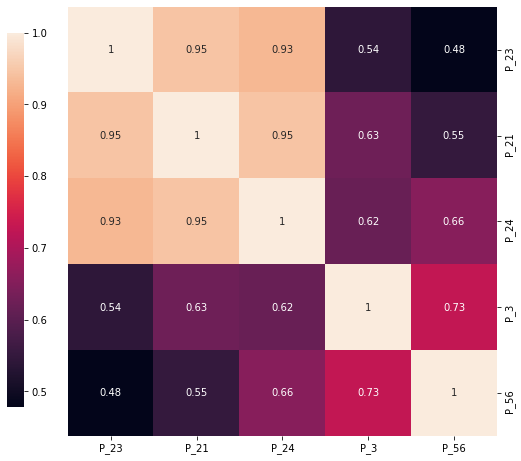

In [71]:
cg = sns.clustermap(cluster_8.corr(), figsize=(8, 8), cbar_pos=(.1, .1, .03, .65), annot=True)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
plt.show()

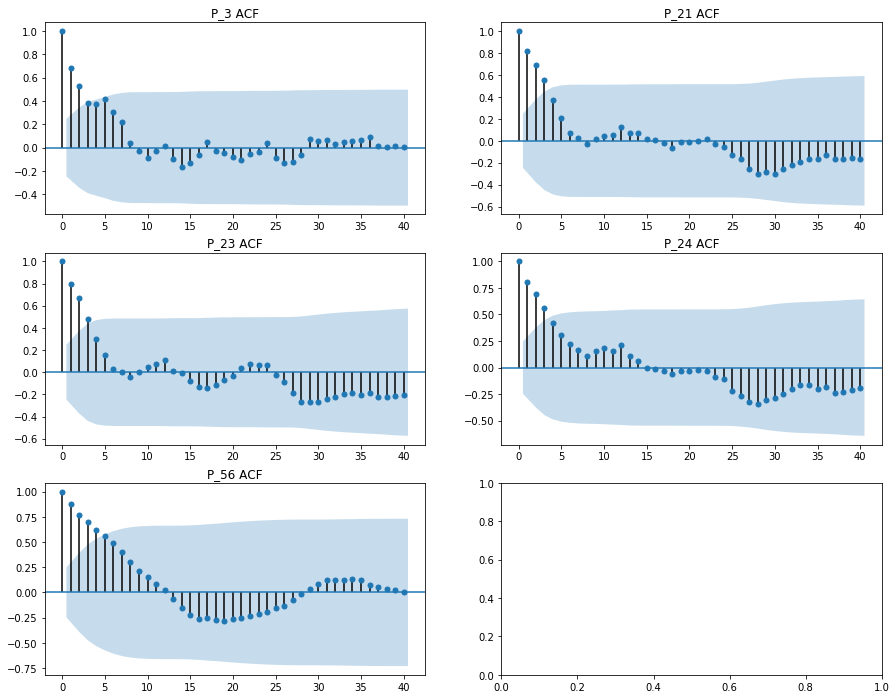

In [72]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=False)
axs = axes.flatten()
alpha=.05
for i, col in enumerate(cluster_8.columns):
    sm.graphics.tsa.plot_acf(cluster_8[col].values.squeeze(), lags=40, ax=axs[i], title=f"{col} ACF", alpha=alpha)

In [158]:
multiple_test_all(cluster_8)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_3,Non,Oui,1,Oui,Oui,Non,1
P_21,Non,Non,0,Oui,Oui,Oui,1
P_23,Non,Oui,1,Oui,Non,Oui,1
P_24,Non,Non,0,Oui,Oui,Oui,1
P_56,Non,Non,0,Oui,Oui,Oui,1


In [157]:
def choose_d(l):
    return list(sorted(l))[1]
def Oui_non(x): 
    return "Oui" if x else "Non"
def test_all(y):
    y = y.dropna()
    n_ch = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ocsb')
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    return (Oui_non(n_ch), Oui_non(n_ocsb), max(n_ch, n_ocsb), Oui_non(n_adf), \
            Oui_non(n_kpss), Oui_non(n_pp), choose_d((n_adf, n_kpss, n_pp)))
def multiple_test_all(df):
    res = pd.DataFrame(df.columns, columns=["Series"])
    res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(df[i])[j]\
                                               for i in df.columns] for j in range(7)]
    res=res.set_index("Series")
    res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
    return res

In [159]:
def remove_trend(y):
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    n_diff=max(n_adf, n_kpss, n_pp)
    for i in range(n_diff):
        y = y.diff(1)
    return {"serie" : y, "n_diff" : n_diff}
def stationnarise(y):
    y ,n_diff = remove_trend(y).values()
    y = y.dropna()
    n_ch = nsdiffs(y, m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(y, m=12, max_D=12, test='ocsb')
    n_sdiff=max(n_ch, n_ocsb)
    for i in range(n_sdiff):
        y = y.diff(12)
    return {"serie" : y, "n_diff" : n_diff, "n_sdiff" : n_sdiff}

In [160]:
def series_from_summary(summary):
    return pd.DataFrame([dic['serie'] for dic in summary.values()]).T

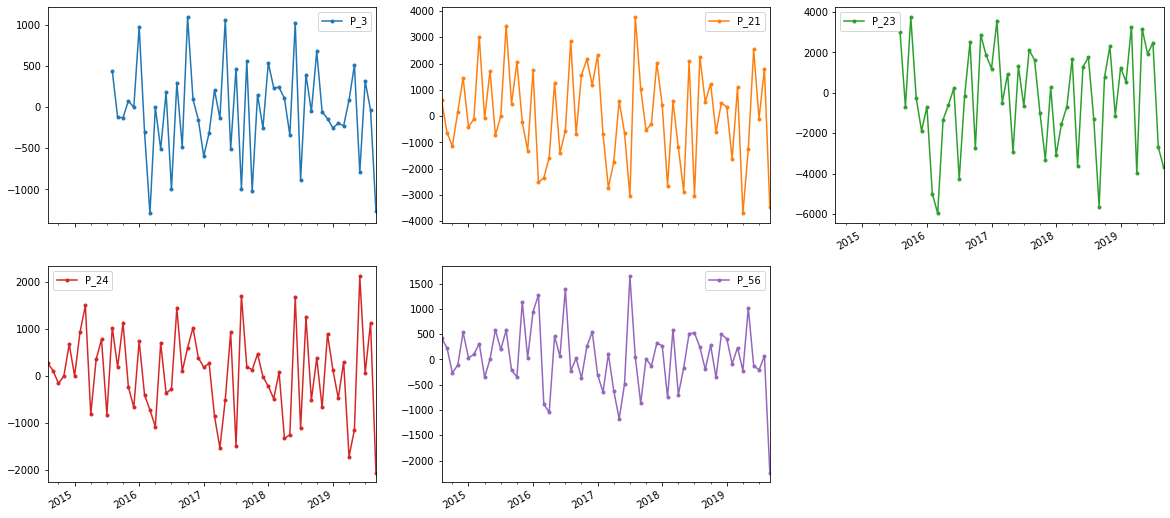

In [161]:
stationnarisation_summary  = {key: 0 for key in cluster_8.columns}
for col in cluster_8.columns:
    stationnarisation_summary[col] = stationnarise(cluster_8_train__var[col])
cluster_8_s = series_from_summary(stationnarisation_summary)
cluster_8_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

In [265]:
train_var = cluster_8_s.loc[:'2018-12-31']
test_var = cluster_8_s.loc['2019-01-31':] 

In [187]:
train_var

,P_3,P_21,P_23,P_24,P_56
2014-08-31,NaN,605.0,NaN,273.0,422.0
2014-09-30,NaN,-621.0,NaN,115.0,232.0
2014-10-31,NaN,-1139.0,NaN,-157.0,-263.0
2014-11-30,NaN,151.0,NaN,-1.0,-113.0
2014-12-31,NaN,1465.0,NaN,675.0,537.0
2015-01-31,NaN,-409.0,NaN,2.0,34.0
2015-02-28,NaN,-108.0,NaN,930.0,99.0
2015-03-31,NaN,3028.0,NaN,1498.0,316.0
2015-04-30,NaN,-77.0,NaN,-815.0,-350.0
2015-05-31,NaN,1725.0,NaN,353.0,7.0


In [164]:
multiple_test_all(cluster_8_s)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_3,Non,Non,0,Non,Non,Non,0
P_21,Non,Non,0,Non,Non,Non,0
P_23,Non,Non,0,Oui,Non,Non,0
P_24,Non,Non,0,Non,Non,Non,0
P_56,Non,Non,0,Non,Non,Non,0


In [165]:
stationnarisation_summary

{'P_3': {'serie': 2014-08-31       NaN
  2014-09-30       NaN
  2014-10-31       NaN
  2014-11-30       NaN
  2014-12-31       NaN
                 ...  
  2019-05-31     510.0
  2019-06-30    -793.0
  2019-07-31     318.0
  2019-08-31     -36.0
  2019-09-30   -1266.0
  Name: P_3, Length: 62, dtype: float64,
  'n_diff': 1,
  'n_sdiff': 1},
 'P_21': {'serie': 2014-08-31     605.0
  2014-09-30    -621.0
  2014-10-31   -1139.0
  2014-11-30     151.0
  2014-12-31    1465.0
                 ...  
  2019-05-31   -1246.0
  2019-06-30    2539.0
  2019-07-31     -95.0
  2019-08-31    1805.0
  2019-09-30   -3463.0
  Name: P_21, Length: 62, dtype: float64,
  'n_diff': 1,
  'n_sdiff': 0},
 'P_23': {'serie': 2014-08-31       NaN
  2014-09-30       NaN
  2014-10-31       NaN
  2014-11-30       NaN
  2014-12-31       NaN
                 ...  
  2019-05-31    3167.0
  2019-06-30    1928.0
  2019-07-31    2482.0
  2019-08-31   -2698.0
  2019-09-30   -3693.0
  Name: P_23, Length: 62, dtype: float64,
  

In [190]:
from statsmodels.tsa.stattools import grangercausalitytests

In [193]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]].dropna(), maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(train_var, variables = train_var.columns)

,P_3_x,P_21_x,P_23_x,P_24_x,P_56_x
P_3_y,1.0000,0.0000,0.0,0.0000,0.0000
P_21_y,0.0000,1.0000,0.0,0.0000,0.0000
P_23_y,0.0000,0.0000,1.0,0.0000,0.0067
P_24_y,0.0000,0.0000,0.0,1.0000,0.0193
P_56_y,0.1915,0.0123,0.0,0.0001,1.0000


In [204]:
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR

from scipy.stats import pearsonr

In [280]:
mod = VAR(endog=train_var.dropna())
# res = mod.fit(maxlags=6, ic='aic')
# print(res.summary())

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [271]:
model_fit = mod.fit(maxlags=12)
prediction = model_fit.forecast(model_fit.y, steps=len(test_var))

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


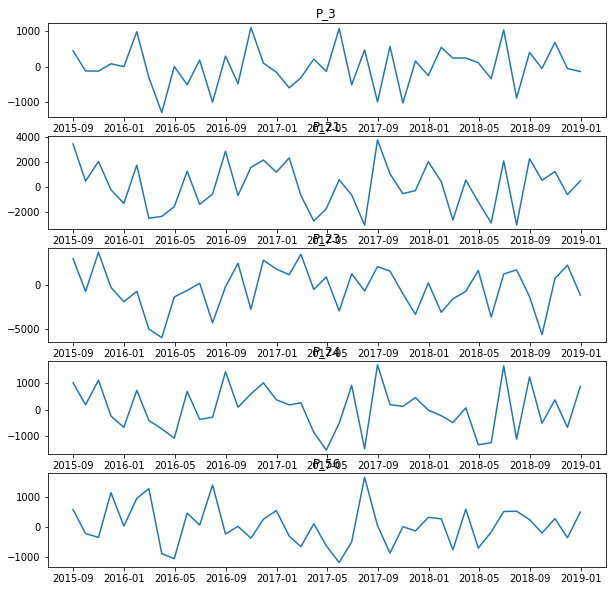

In [278]:
model_fit.plot();

In [272]:
model_fit.summary()

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1416: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Jun, 2021
Time:                     20:29:51
---------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    -236.651
Nobs:                     29.0000    HQIC:                   -246.528
Log likelihood:           3739.21    FPE:               -1.22651e-116
AIC:                     -251.032    Det(Omega_mle):    -4.26040e-119
---------------------------------------------------------------------
Results for equation P_3
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000041         0.000000          125.306           0.000
L1.P_3          -0.088394         0.000000     -7177520.388           0.000
L1.P_21         -0.103101              NAN              NAN             NAN


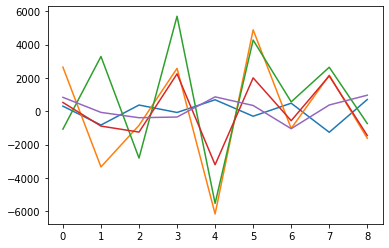

In [273]:
plt.plot(prediction)

In [274]:
prediction.T

array([[  303.02105476,  -828.68586364,   370.66962796,   -75.25542046,
          686.12887273,  -301.39144838,   480.43180563, -1261.84691122,
          701.05730431],
       [ 2641.89006084, -3341.26095075,  -847.23565938,  2571.50674488,
        -6158.00911247,  4880.2703796 , -1033.88316815,  2160.61157639,
        -1621.22297347],
       [-1073.42369758,  3282.53934485, -2808.54565012,  5694.48330842,
        -5525.86109252,  4266.50387163,   560.75308609,  2636.59169882,
         -737.86498273],
       [  525.07932808,  -891.69656758, -1252.04691044,  2239.87012346,
        -3208.79677322,  1999.36870861,  -568.49370906,  2116.8072296 ,
        -1454.94432958],
       [  831.63632092,   -70.7751192 ,  -389.77820489,  -349.11118633,
          860.51684011,   343.38743191, -1047.51710904,   373.02391396,
          960.35212834]])

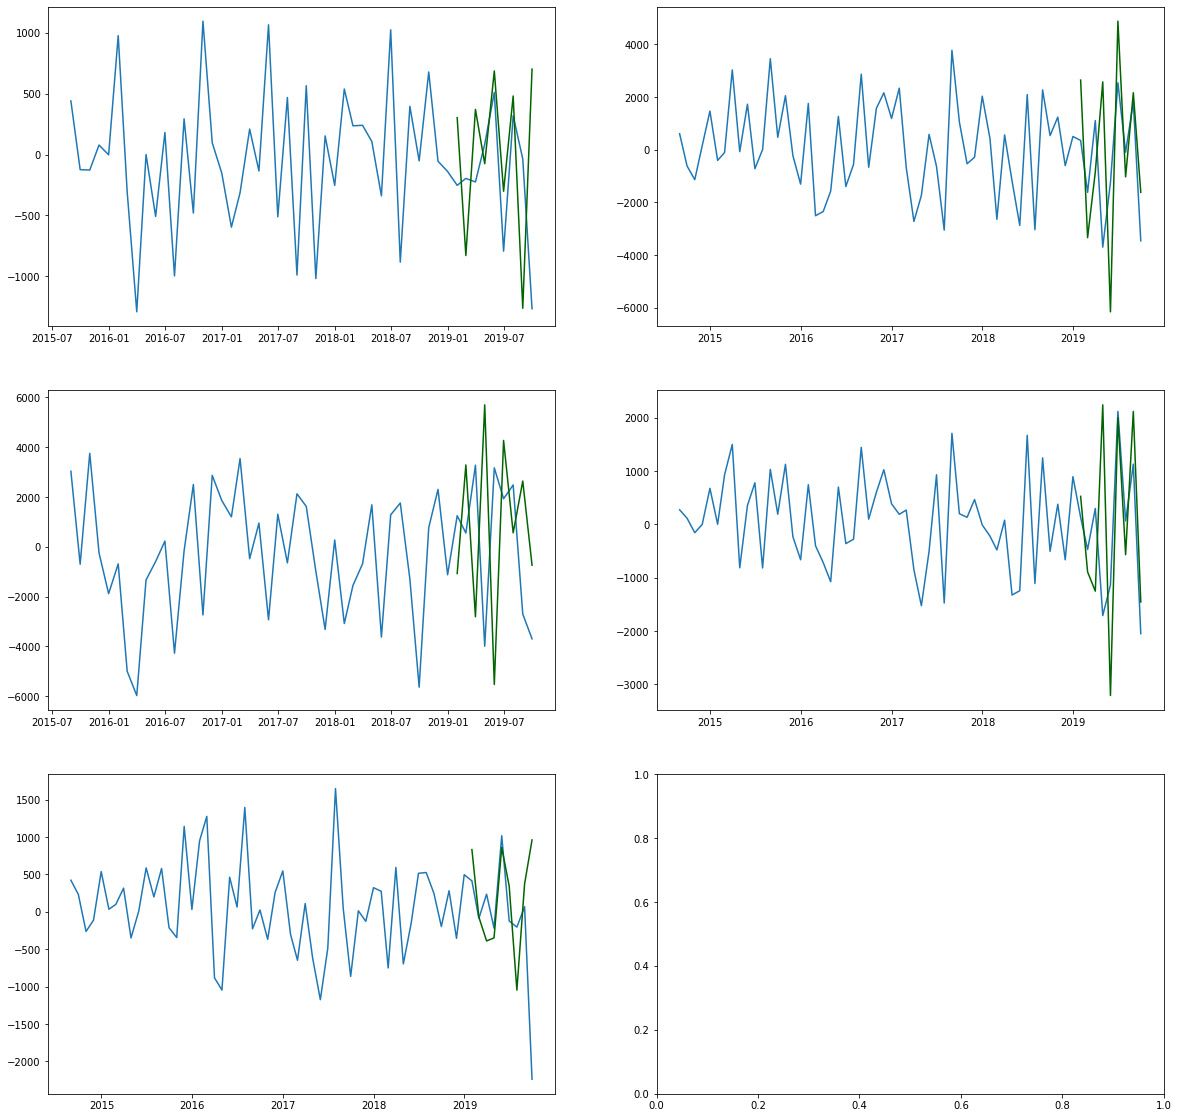

In [276]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()
# index_of_fc = sales_s.loc['2019-01-31':].index
for i, p in enumerate(prediction.T) :
    fc_series = pd.Series(p, index=cluster_8.loc['2019-01-31':].index)
    axs[i].plot(cluster_8_s.iloc[:,i], label="actual")
    axs[i].plot(fc_series, color='darkgreen', label="forecast")

In [251]:
x = mod.select_order(maxlags=7)
x.summary()

LinAlgError: 4-th leading minor of the array is not positive definite